In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy
import time
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from utils import get_days_table_cest, get_taps_all, get_intervals, estimate_JID, prepare_plot, make_cmap, run_cluster_test

## Data import

### Import tappigraphy data

In [4]:
# Path where to find the downloaded data
raw_data_dir = r"data"

# Participation ID
part_id = '138e923b6c7ca01141e7b587d5662942a86c28eb'

# Define study start en stop date
start_date = datetime.date(2021, 4, 28)
end_date = datetime.date(2021, 10, 29)

# Define at what hours after 12pm to start each new day
hour_offset = 4

# Get list of all study days
data = get_days_table_cest(start_date, end_date, hour_offset=hour_offset)

# Get taps of all study days
taps = get_taps_all(part_id, raw_data_dir)
taps = np.array(taps)

# Separate all taps per study day
taps_day_list = []
for index, day in data.iterrows():
    epoch = day['Epoch Time']
    taps_day = taps[taps >= epoch]
    taps_day = taps_day[taps_day < epoch+24*60*60*1000]
    taps_day_list.append(taps_day)
data['Taps'] = pd.Series(taps_day_list)

# Get datetimes from epoch for each study day
day_epochs = data['Epoch Time']/1000
data['Datetimes'] = [datetime.datetime.fromtimestamp(epoch) for epoch in day_epochs]

# Count taps per day
n_taps = []
for index, day in data.iterrows():
    epoch = day['Epoch Time']
    taps_day = taps[taps >= epoch]
    taps_day = taps_day[taps_day < epoch+24*60*60*1000]
    n_taps.append(len(taps_day))
data['Number of taps'] = n_taps

c:\Users\arvannieuwamerongen\Documents\PhD\2-studies\Smartphone-I\scripts\Casestudy_epi_SEIN_2023\qaparser.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tds = tds.append(dev)


Found 1 device(s) of type Phone


### Import sleep duration data

In [5]:
# Import sleep data
mat = scipy.io.loadmat(r'data\corrected_sleep_speed.mat')
data['Sleep duration'] = mat['X_SleepDurationH_corrected'][0]

### Import seizure and medication data

In [6]:
# Import seizure information
seizures = pd.read_csv(r"data\seizures.csv", sep=';')
data['Focal impaired aware'] = seizures['Focal impaired aware']
data['Tonic clonic'] = seizures['Tonic clonic']
data['Cluster'] = seizures['Cluster']

fia_days = data['Datetimes'][data['Focal impaired aware']].tolist()
tc_days = data['Datetimes'][data['Tonic clonic']].tolist()

# Import medication
medication = pd.read_csv(r"data\medication_during_PCS_v3.csv", sep=';')

data['LTG'] = medication['Lamotrigine (mg)']
data['PER'] = medication['Perampanel (mg)']
data['DDD'] = medication['DDD']
data['Tapering'] = medication['Tapering']

# Label days based on their position relative to the tapering period
start_tapering = datetime.datetime(2021, 7, 19, hour_offset, 0, 0)
stop_tapering = datetime.datetime(2021, 7, 30, hour_offset, 0, 0)

data['Position to tapering'] = None
datetimes = pd.to_datetime(data['Datetimes'])

data.loc[datetimes < start_tapering, 'Position to tapering'] = 'Pre-tapering'
data.loc[data['Tapering'], 'Position to tapering'] = 'Tapering'
data.loc[datetimes > stop_tapering, 'Position to tapering'] = 'Post-tapering'

### Display medication and seizures during study period

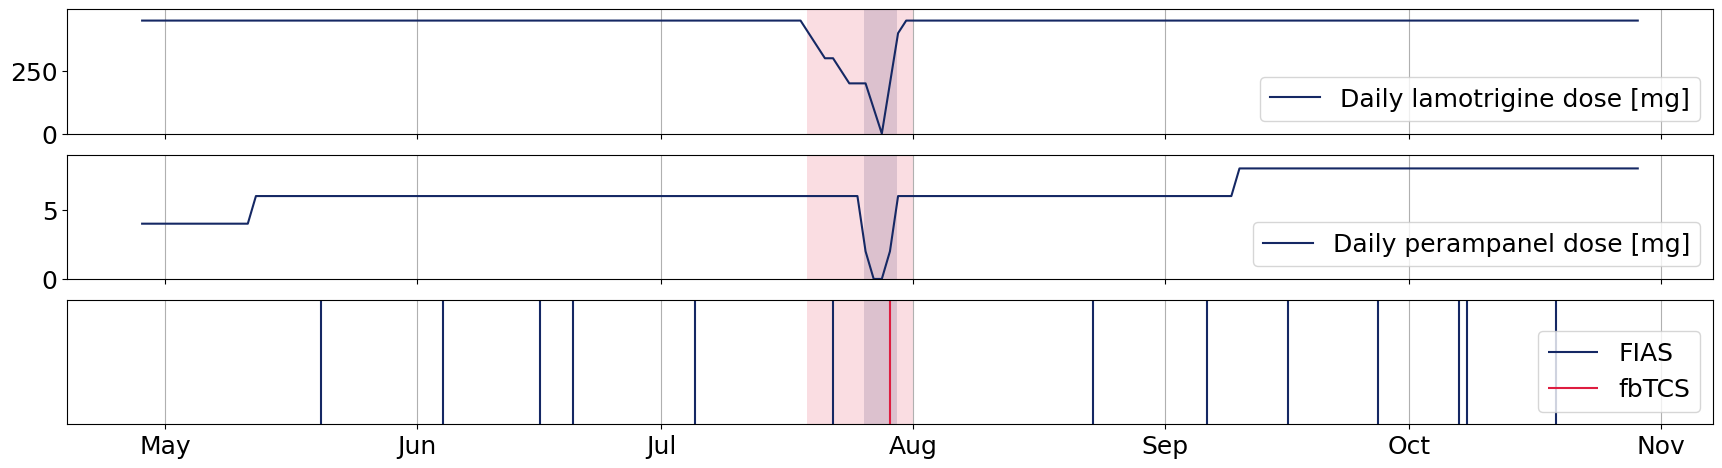

In [7]:
day_epochs = data['Epoch Time']/1000
data['Datetimes'] = [datetime.datetime.fromtimestamp(epoch) for epoch in day_epochs]

locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')

plt.rcParams.update({'font.size': 18})
f, axs = plt.subplots(3, 1, sharex='col', figsize=(18, 5))

axs[0].plot(data['Datetimes'], data['LTG'], label='Daily lamotrigine dose [mg]', color='#152864')
axs[0].grid(axis='x')
axs[0].legend(loc='lower right')
axs[0].set_ylim(0, 495)

axs[1].plot(data['Datetimes'], data['PER'], label='Daily perampanel dose [mg]', color='#152864')
axs[1].grid(axis='x')
axs[1].legend(loc='lower right')
axs[1].set_ylim(0, 9)

axs[2].vlines(fia_days, ymin=0, ymax=1, color='#152864', label='FIAS')
axs[2].vlines(tc_days, ymin=0, ymax=1, color='#DE1D40', label='fbTCS')
axs[2].grid(axis='x')
axs[2].legend(loc='lower right')
axs[2].set_yticks([])
axs[2].set_ylim(0, 1)

line_days = range(0, 5)
vertical_line_positions = [datetime.date(2021, 7, 26) + datetime.timedelta(days=day) for day in line_days]
rect0 = Rectangle((vertical_line_positions[0], 0), vertical_line_positions[-1] - vertical_line_positions[0], 495,
                  linewidth=0, facecolor='#152864', alpha=0.15)
rect1 = Rectangle((vertical_line_positions[0], 0), vertical_line_positions[-1] - vertical_line_positions[0], 9,
                  linewidth=0, facecolor='#152864', alpha=0.15)
rect2 = Rectangle((vertical_line_positions[0], 0), vertical_line_positions[-1] - vertical_line_positions[0], 1,
                  linewidth=0, facecolor='#152864', alpha=0.15)

line_days = range(0, 14)
vertical_line_positions = [datetime.date(2021, 7, 19) + datetime.timedelta(days=day) for day in line_days]
tap_rect0 = Rectangle((vertical_line_positions[0], 0), vertical_line_positions[-1] - vertical_line_positions[0], 495,
                      linewidth=0, facecolor='#DE1D40', alpha=0.15)
tap_rect1 = Rectangle((vertical_line_positions[0], 0), vertical_line_positions[-1] - vertical_line_positions[0], 9,
                      linewidth=0, facecolor='#DE1D40', alpha=0.15)
tap_rect2 = Rectangle((vertical_line_positions[0], 0), vertical_line_positions[-1] - vertical_line_positions[0], 1,
                      linewidth=0, facecolor='#DE1D40', alpha=0.15)

axs[0].add_patch(rect0)
axs[1].add_patch(rect1)
axs[2].add_patch(rect2)
axs[0].add_patch(tap_rect0)
axs[1].add_patch(tap_rect1)
axs[2].add_patch(tap_rect2)

font = {'family': 'normal',
        'weight': 'bold',
        'size': 22}

plt.subplots_adjust(top=0.977,
                    bottom=0.147,
                    left=0.071,
                    right=0.985,
                    hspace=0.169,
                    wspace=0.2)

X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)

cur_Date = time.strftime("%Y-%m-%d")
cur_Time = time.strftime("%H-%M-%S")

plt.show()

## Analysis

### Estimate daily joint interval distributions (JID)

In [8]:
zs = []
for index, day in data.iterrows():
    taps_all = day['Taps']
    dt1, dt2 = get_intervals(taps_all)
    x, JID, z = estimate_JID(dt1, dt2, title=day['Date'], plot=False, BINS=50, bandwidth=0.1)
    zs.append(z)

data['JID'] = zs

### Display JIDs during pre-tapering, tapering and post-tapering period

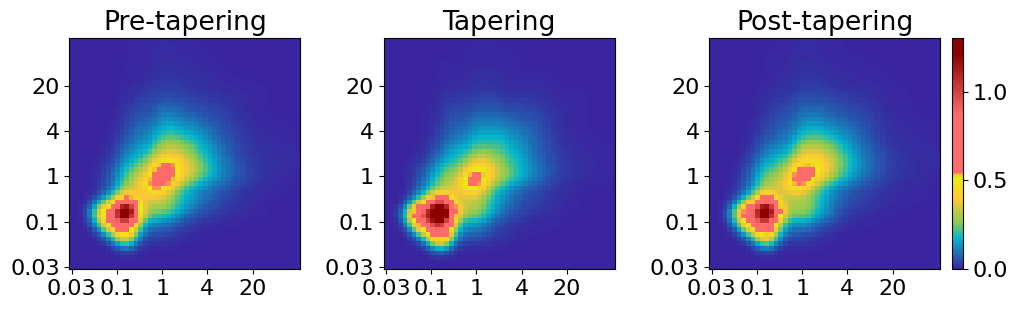

In [9]:
# Prepare data
pretaper_days = data[data['Position to tapering'] == 'Pre-tapering']
taper_days = data[data['Position to tapering'] == 'Tapering']
posttaper_days = data[data['Position to tapering'] == 'Post-tapering']

zs_pretaper = np.array(list(pretaper_days['JID']))
zs_taper = np.array(list(taper_days['JID']))
zs_posttaper = np.array(list(posttaper_days['JID']))

zs_pretaper_mean = np.mean(zs_pretaper, axis=0)
zs_taper_mean = np.mean(zs_taper, axis=0)
zs_posttaper_mean = np.mean(zs_posttaper, axis=0)

JIDs_taper = [zs_pretaper_mean, zs_taper_mean, zs_posttaper_mean]
JIDs_titles = ['Pre-tapering', 'Tapering', 'Post-tapering']
JIDs_names = ['pretapering', 'tapering', 'posttapering']

# Prepare plot
cvals = [0, 0.2, 0.3, 0.45, 0.59, 0.62, 0.628, 1.0, 1.4, 1.5]
colors = ["#3A239E", "#02B7CC", "#88CB53", "#FEC735", "#EBEB14", "#F3B638", "#FF6B6B", "#FF6B6B", "#8C0000", "#8C0000"]

norm = plt.Normalize(min(cvals), max(cvals))
tuples = list(zip(map(norm, cvals), colors))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

plt.rcParams.update({'font.size': 16})
fig, axis = plt.subplots(1, 3, figsize=(14, 3), width_ratios=[1, 1, 1.08])

for i, JID in enumerate(JIDs_taper):
    im = axis[i].imshow(np.reshape(JID, (50, 50)), cmap=cmap, vmin=0, vmax=1.3, origin='lower')
    prepare_plot(axis[i], xlabel=False, ylabel=False)
    cur_Date = time.strftime("%Y%m%d")
    cur_Time = time.strftime("%H%M%S")
    if i in (0, 1):
        plt.subplots_adjust(left=0.15)
    elif i == 2:
        plt.subplots_adjust(right=0.8)
        plt.colorbar(im, ax=axis[i], fraction=0.046, pad=0.04)
    axis[i].title.set_text(JIDs_titles[i])

### Display contrasts between pre-tapering and tapering period, and between tapering and post-tapering period

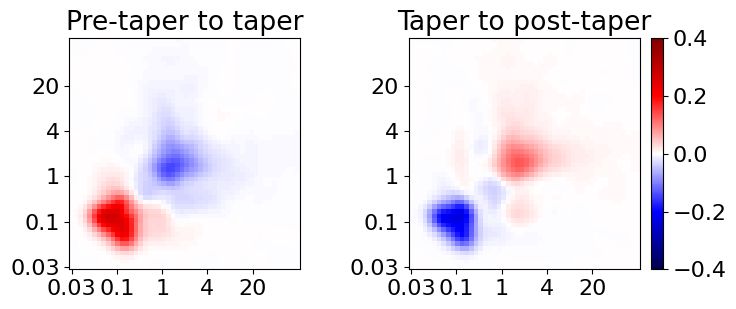

In [10]:
JIDs_taper = [zs_taper_mean-zs_pretaper_mean, zs_posttaper_mean-zs_taper_mean]
JIDs_titles = ['Pre-taper to taper', 'Taper to post-taper']
JIDs_names = ['pretaper_to_taper', 'taper_to_posttaper']

fig, axis = plt.subplots(1, 2, figsize=(8, 3))
plt.rcParams.update({'font.size': 16})

for i, JID in enumerate(JIDs_taper):
    im = axis[i].imshow(np.reshape(JID, (50, 50)), cmap='seismic', vmin=-0.4, vmax=0.4, origin='lower')
    prepare_plot(axis[i], xlabel=False, ylabel=False)
    cur_Date = time.strftime("%Y%m%d")
    cur_Time = time.strftime("%H%M%S")
    if i == 1:
        plt.colorbar(im, ax=axis[i], fraction=0.046, pad=0.04)
    axis[i].title.set_text(JIDs_titles[i])

### Prepare data for cluster-based permutation

In [11]:
pretaper_days = data[data['Position to tapering'] == 'Pre-tapering']
taper_days = data[data['Position to tapering'] == 'Tapering']
posttaper_days = data[data['Position to tapering'] == 'Post-tapering']
nontaper_days = data[~data['Tapering']]

zs_pretaper = np.array(list(pretaper_days['JID']))
zs_taper = np.array(list(taper_days['JID']))
zs_posttaper = np.array(list(posttaper_days['JID']))
zs_nontaper = np.array(list(nontaper_days['JID']))

p_value = 0.01  # one-tailed p-value threshold for which 2D bins to include in a cluster

### Perform cluster-based permutation testing for **pre-tapering** to **tapering** transition

The median maximal cluster size is 17 [10 - 27]
Found significant cluster with size 243.0 (p=0.006)
Found significant cluster with size 84.0 (p=0.033)


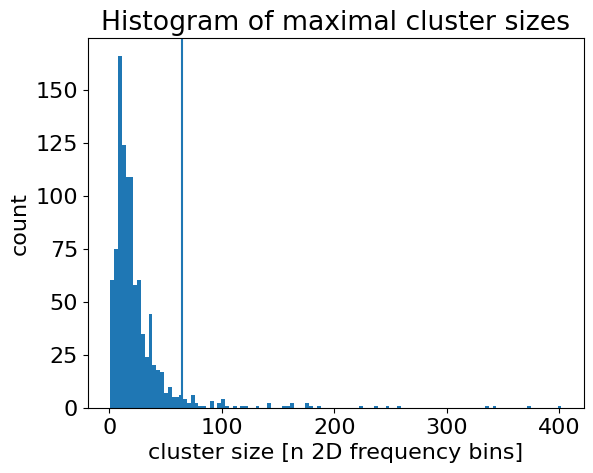

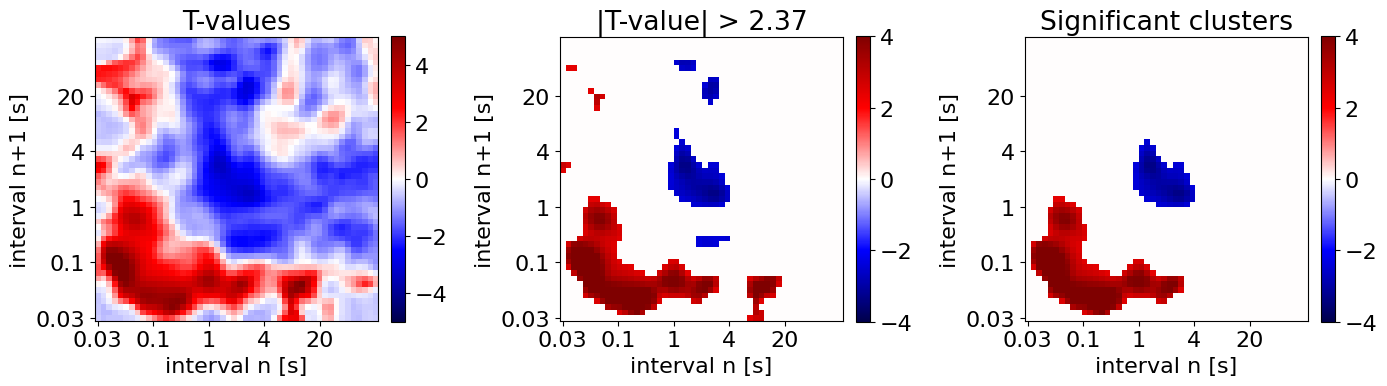

In [12]:
df = len(zs_pretaper) + len(zs_taper) - 2  # degrees of freedom
t_threshold = stats.t.ppf(1 - p_value, df)  # corresponding t-statistic as threshold to be used as threshold for clustering

run_cluster_test(zs, zs_taper, zs_pretaper, t_threshold)

### Perform cluster-based permutation testing for **tapering** to **post-tapering** transition

The median maximal cluster size is 17 [10 - 28]
Found significant cluster with size 147.0 (p=0.007)
Found significant cluster with size 156.0 (p=0.007)


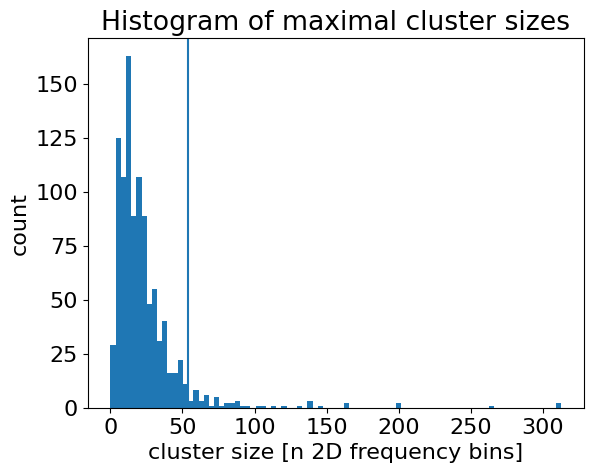

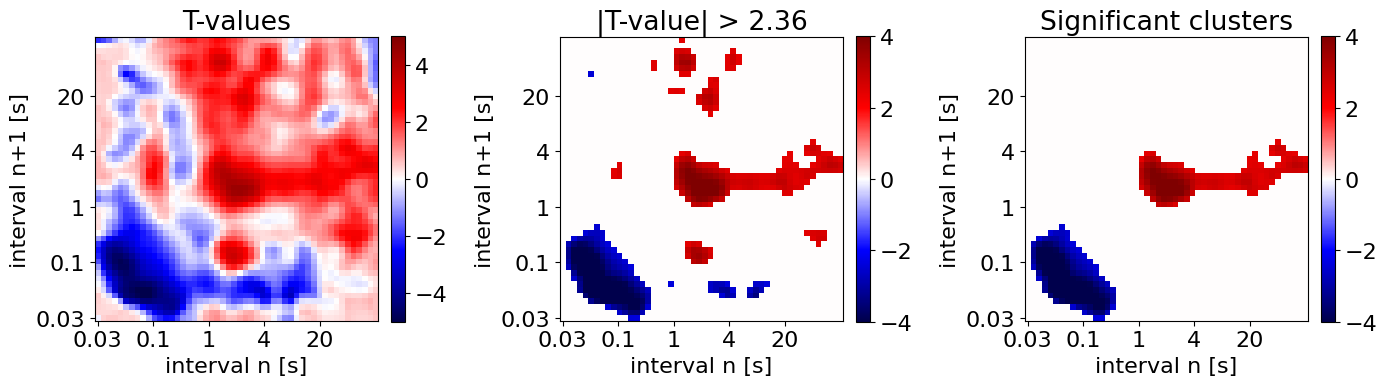

In [13]:
df = len(zs_taper) + len(zs_posttaper) - 2  # degrees of freedom
t_threshold = stats.t.ppf(1 - p_value, df)  # corresponding t-statistic to be used as threshold for clustering

run_cluster_test(zs, zs_posttaper, zs_taper, t_threshold)

### Display daily JIDs during admission to the epilepsy monitoring unit

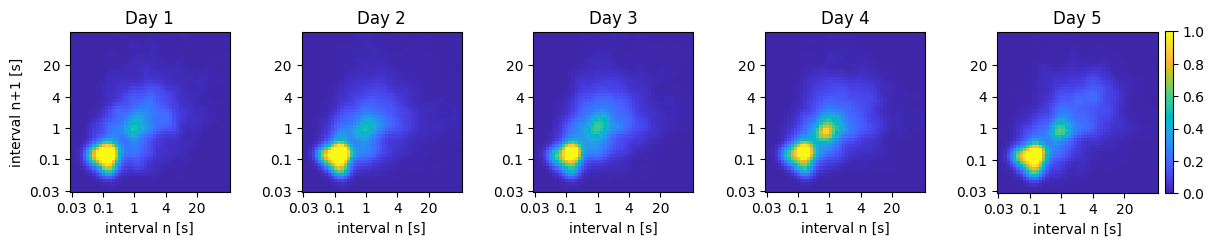

In [14]:
# Slice EMU days from data table
start_date = datetime.datetime(2021, 7, 26)+datetime.timedelta(hours=hour_offset)
start_date_index = data[data['Datetimes'] == start_date].index
n_days = 5
date_slices = range(start_date_index[0], start_date_index[0]+n_days)
data_sliced = data.iloc[date_slices]
data_sliced = data_sliced.reset_index()

# Prepare plot
cmap = make_cmap()
plt.rcParams.update({'font.size': 10})
fig, axs = plt.subplots(1, 5, figsize=(12, 3), width_ratios=[1, 1, 1, 1, 1.1])

for index, day in data_sliced.iterrows():
    im = axs[index].imshow(np.reshape(day['JID'], (50, 50)), cmap=cmap, vmin=0, vmax=1.0, origin='lower')
    axs[index].title.set_text('Day {}'.format(index+1))
    if index == 0:
        prepare_plot(axs[index])
    else:
        prepare_plot(axs[index], ylabel=False)
    if index == 4:
        plt.colorbar(im, ax=axs[index], fraction=0.046, pad=0.04)
plt.subplots_adjust(top=0.96, bottom=0.04, left=0.07, right=0.989, hspace=1, wspace=0.44)
plt.show()

### Display contrast between a convulsive seizure day (day 4) and the preceeding non-convulsive days (day 1-3)

Text(0.5, 1.0, 'Day 1-3 vs. day 4')

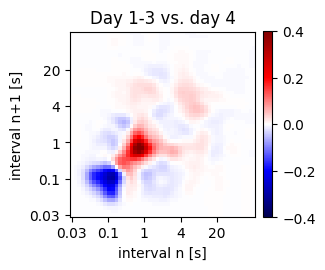

In [15]:
# Prepare contrast data
nonTC_EMU = np.mean(np.array([data_sliced['JID'][0], data_sliced['JID'][1], data_sliced['JID'][2]]), axis=0)
TC_EMU = data_sliced['JID'][3].copy()  # JID of TC-day

# Prepare plot
plt.rcParams.update({'font.size': 10})
fig, axis = plt.subplots(1, figsize=(3, 3))

im_diff = axis.imshow(np.reshape(TC_EMU - nonTC_EMU, (50, 50)), cmap='seismic', vmin=-0.4, vmax=0.4, origin='lower')
plt.colorbar(im_diff, ax=axis, fraction=0.046, pad=0.04)
prepare_plot(axis, xlabel=True, ylabel=True)
plt.subplots_adjust(right=0.8)
plt.title('Day 1-3 vs. day 4')